In [70]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import ssl
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import numpy as np
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [66]:
#reding inn csv files
data = pd.read_csv("Property_Features_Data.csv")

In [45]:
data.corr()

,Stories,beds,baths,price,Days on Market,Year Built,Lot Area
Stories,1.000000,-0.258626,-0.158246,0.212304,-0.046551,0.286283,0.115920
beds,-0.258626,1.000000,0.847426,0.297495,0.296176,-0.113220,0.037632
baths,-0.158246,0.847426,1.000000,0.492749,0.426353,0.008939,-0.072616
price,0.212304,0.297495,0.492749,1.000000,0.186755,0.097627,-0.040941
Days on Market,-0.046551,0.296176,0.426353,0.186755,1.000000,0.088044,-0.052205
Year Built,0.286283,-0.113220,0.008939,0.097627,0.088044,1.000000,0.000932
Lot Area,0.115920,0.037632,-0.072616,-0.040941,-0.052205,0.000932,1.000000


In [46]:
data["Year Built"] = data["Year Built"] - 1849

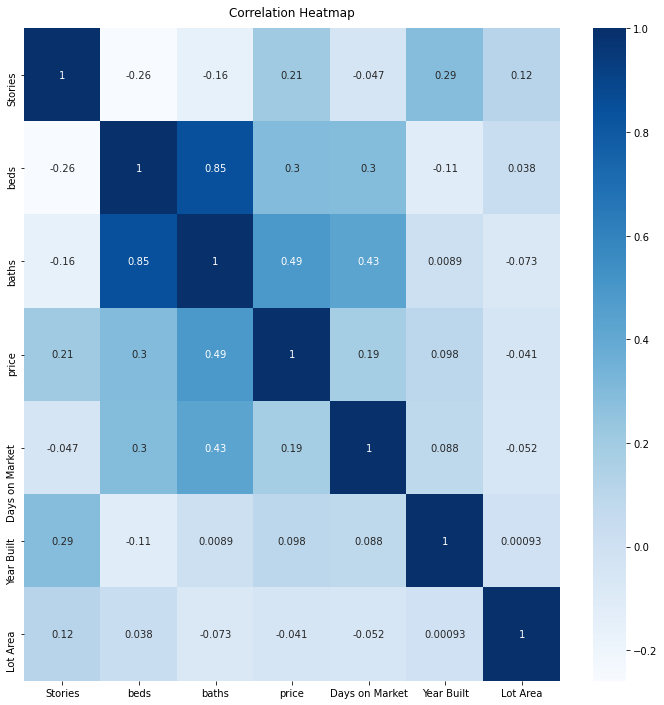

In [47]:
plt.figure(figsize=(12, 12))
feature_heatmap = sns.heatmap(data.corr(), cmap="Blues", annot=True);

feature_heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

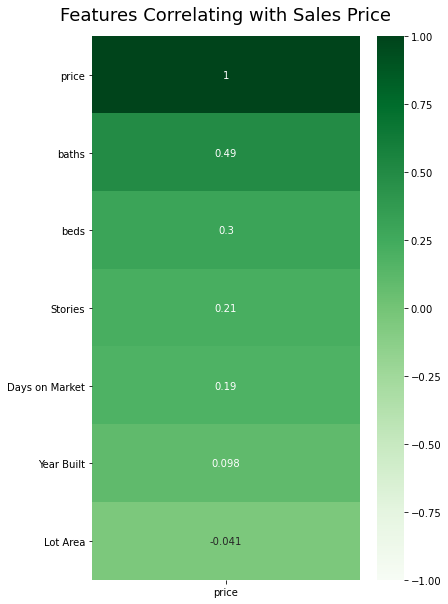

In [48]:
data.corr()[['price']].sort_values(by='price', ascending=False)
plt.figure(figsize=(6, 10))
heatmap = sns.heatmap(data.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='Greens')
heatmap.set_title('Features Correlating with Sales Price', fontdict={'fontsize':18}, pad=16);


In [49]:
#oneh ot encoding propery type
one_hot_encode_property = pd.get_dummies(data["Property Type"], prefix='Property')
data = pd.concat([data, one_hot_encode_property ], axis=1).drop('Property Type', axis=1)

In [50]:
#filling na cols with mean or median col values
data['Stories'] = data['Stories'].fillna(data['Stories'].mean())
data['Lot Area'] = data['Lot Area'].fillna(data['Lot Area'].mean())
data['beds'] = data['beds'].fillna(data['beds'].mean())
data['baths'] = data['baths'].fillna(data['baths'].mean())
data['Year Built'] = data['Year Built'].fillna(data['Year Built'].median())

In [51]:
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE


In [52]:
#not currently used
req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
webpage = urlopen(req).read()  
soup = BeautifulSoup(webpage, 'html.parser')
html = soup.prettify('utf-8')

In [134]:
#Add Borough to each zip code for classification
def return_neighborhood(zip):
  borough = ""
  if zip == "NY":
    return "Other NYC"
  if not math.isnan(float(zip)) and zip.isnumeric():
    zip_code = int(zip)
    if zip_code >= 10001 and zip_code <= 10282:
      borough = "Manhattan"
    elif zip_code >= 10301 and zip_code <= 10314:
      borough = "Staten Island"
    elif zip_code >= 10451 and zip_code <= 10475:
      borough = "Bronx"
    elif zip_code >= 11004 and zip_code <= 11109 or zip_code >= 11351 and zip_code <= 11697:
      borough = "Queens"
    elif zip_code >= 11201 and zip_code <= 11256:
      borough = "Brooklyn"
    else:
      borough = "Other NYC"
  return borough
  

In [135]:
data['Borough'] = data['Zip Code'].apply(return_neighborhood)

In [136]:
boroughs = ["Manhattan", "Staten Island", "Bronx", "Queens", "Brooklyn", "Other NYC"]
check = list(data["Borough"]).count("Manhattan")
count_per_borough = [list(data["Borough"]).count("Manhattan"),
                    list(data["Borough"]).count("Staten Island"), 
                    list(data["Borough"]).count("Bronx"), 
                    list(data["Borough"]).count("Queens"), 
                    list(data["Borough"]).count("Brooklyn"),
                    list(data["Borough"]).count("Other NYC")]
count_per_borough

[266, 124, 110, 332, 275, 21]

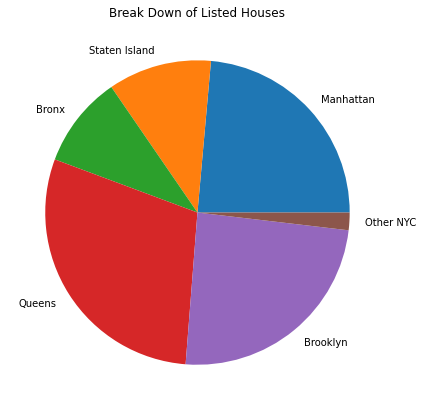

In [137]:
# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.pie(count_per_borough, labels = boroughs)
plt.title("Break Down of Listed Houses")
# show plot
plt.show()

In [138]:
house_price_by_borough = {
  "Manhattan" : [], "Staten Island" : [], "Bronx" : [], "Queens" : [], "Brooklyn" : [], "Other NYC": []
}
for num, row in data.iterrows():
  if not math.isnan(row["price"]):
    house_price_by_borough[row["Borough"]].append(row["price"])

In [140]:
[sum(arr) for (name, arr) in house_price_by_borough.items()]

[530446498.0, 93561352.0, 44994368.0, 278074805.0, 391039927.0, 16553795.0]

In [26]:
#code to create links to livability index
search_link = "https://livabilityindex.aarp.org/search/{borough},%20New%20York%20{zip_code},%20United%20States"
zip_to_score = {}
for zip in set(data['Zip Code'].dropna()):
  if zip.isnumeric():
    borough = ""
    zip_code = int(zip)
    if zip_code >= 10001 and zip_code <= 10282:
      borough = "New%20York"
    elif zip_code >= 10301 and zip_code <= 10314:
      borough = "Staten%20Island"
    elif zip_code >= 10451 and zip_code <= 10475:
      borough = "Bronx"
    elif zip_code >= 11004 and zip_code <= 11109 or zip_code >= 11351 and zip_code <= 11697:
      borough = "Queens"
    else:
      borough = "Brooklyn"
    
    new_link = search_link.format(borough = borough, zip_code = zip_code)
    zip_to_score[zip_code] = new_link
    

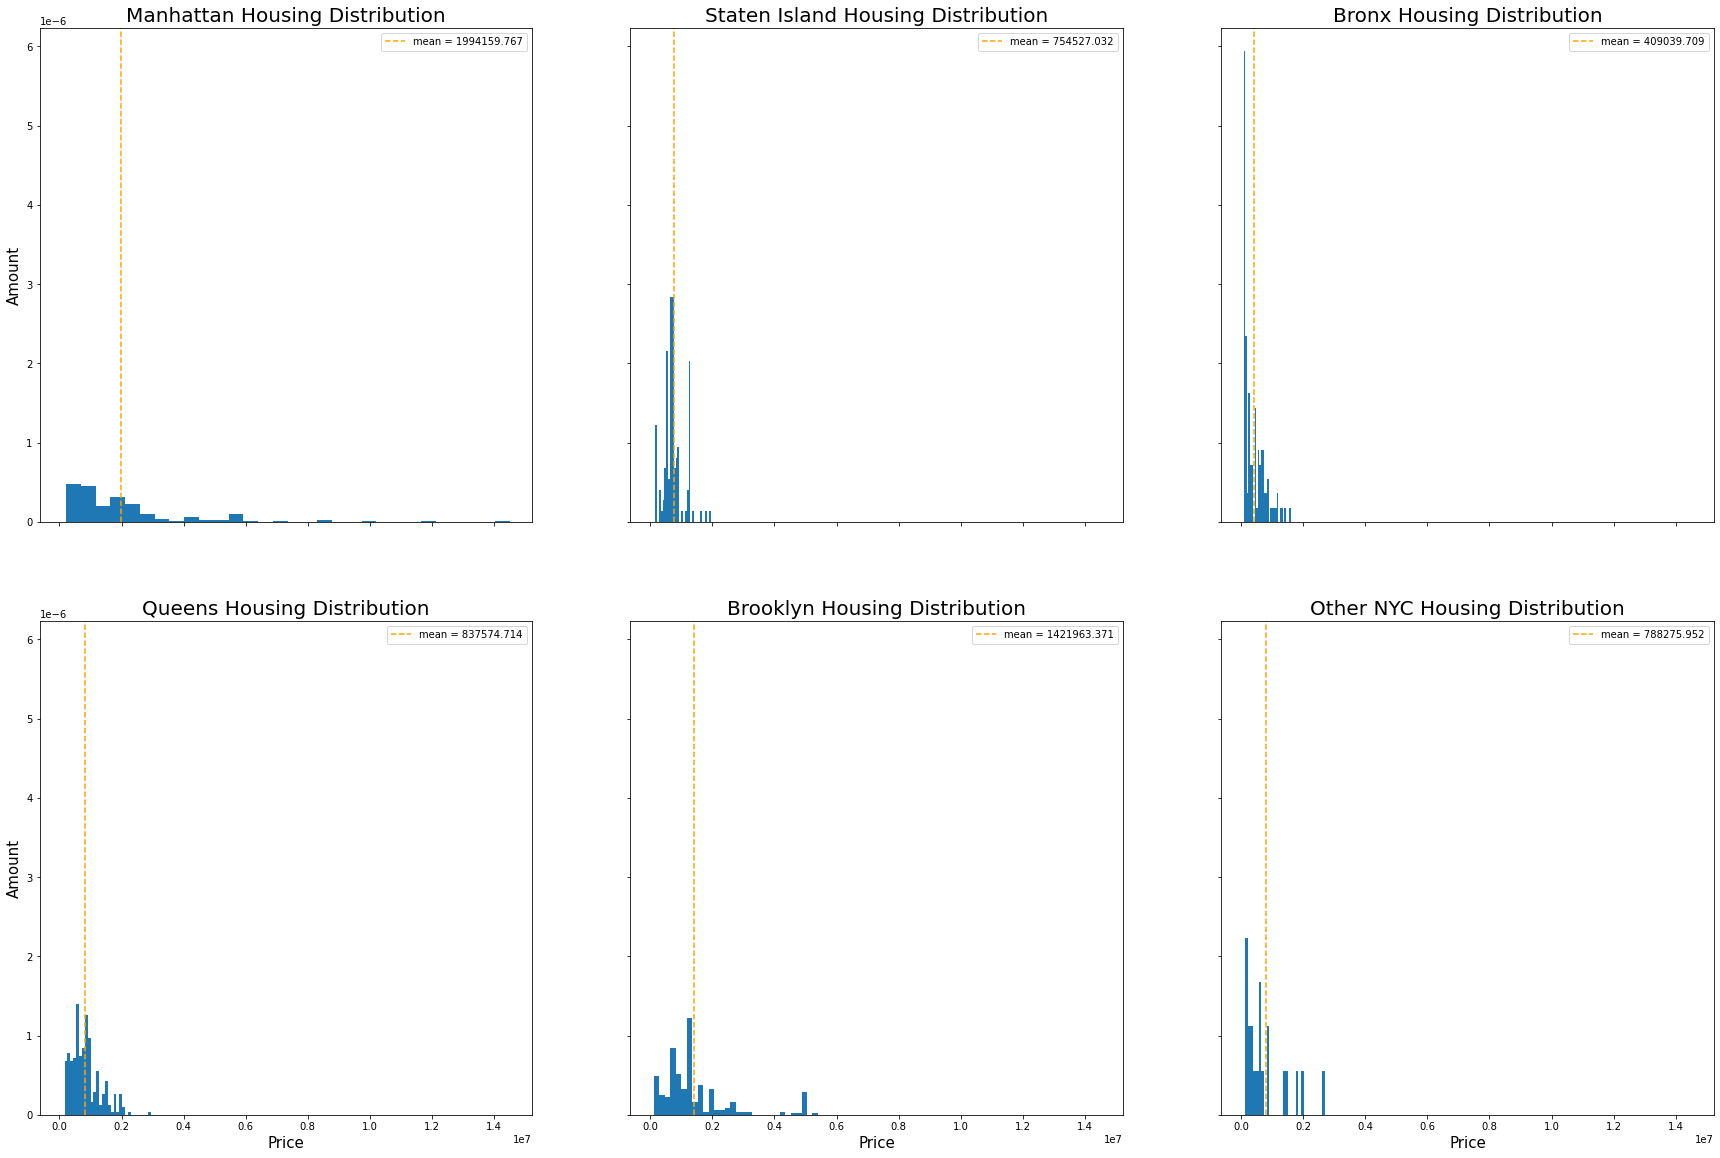

In [180]:
#NEED TO BE FORMATTED BETTER

fig, ax = plt.subplots(2,3, figsize=[30, 20], sharex = True, sharey = True)
[ax[1,i].set_xlabel("Price", fontsize=15) for i in range(3)]
[ax[i,0].set_ylabel("Amount", fontsize=15) for i in range(2)]
ax[0, 0].set_title("Manhattan Housing Distribution", fontsize=20); ax[0,0].hist(house_price_by_borough["Manhattan"], bins=30, density=True); ax[0,0].axvline(np.mean(house_price_by_borough["Manhattan"]), ls="--",c="orange"); ax[0,0].legend(["mean = " + str(round(np.mean(house_price_by_borough["Manhattan"]), 3))])
ax[0, 1].set_title("Staten Island Housing Distribution", fontsize=20); ax[0,1].hist(house_price_by_borough["Staten Island"], bins=30, density=True); ax[0,1].axvline(np.mean(house_price_by_borough["Staten Island"]), ls="--",c="orange"); ax[0,1].legend(["mean = " + str(round(np.mean(house_price_by_borough["Staten Island"]), 3))])
ax[0, 2].set_title("Bronx Housing Distribution", fontsize=20); ax[0,2].hist(house_price_by_borough["Bronx"], bins=30, density=True); ax[0,2].axvline(np.mean(house_price_by_borough["Bronx"]), ls="--",c="orange"); ax[0,2].legend(["mean = " + str(round(np.mean(house_price_by_borough["Bronx"]), 3))])
ax[1, 0].set_title("Queens Housing Distribution", fontsize=20); ax[1,0].hist(house_price_by_borough["Queens"], bins=30, density=True); ax[1,0].axvline(np.mean(house_price_by_borough["Queens"]), ls="--",c="orange"); ax[1,0].legend(["mean = " + str(round(np.mean(house_price_by_borough["Queens"]), 3))])
ax[1, 1].set_title("Brooklyn Housing Distribution", fontsize=20); ax[1,1].hist(house_price_by_borough["Brooklyn"], bins=30, density=True); ax[1,1].axvline(np.mean(house_price_by_borough["Brooklyn"]), ls="--",c="orange"); ax[1,1].legend(["mean = " + str(round(np.mean(house_price_by_borough["Brooklyn"]), 3))])
ax[1, 2].set_title("Other NYC Housing Distribution", fontsize=20); ax[1,2].hist(house_price_by_borough["Other NYC"], bins=30, density=True); ax[1,2].axvline(np.mean(house_price_by_borough["Other NYC"]), ls="--",c="orange"); ax[1,2].legend(["mean = " + str(round(np.mean(house_price_by_borough["Other NYC"]), 3))])

In [4]:
#binary encoding Zip Code
mlb = MultiLabelBinarizer()
zip_cols = mlb.fit_transform(data['Zip Code'].astype(str))
zip_df = pd.DataFrame(zip_cols)
zip_df.columns = ["zip_1","zip_2","zip_3","zip_4","zip_5","zip_6","zip_7","zip_8","zip_9","zip_10","zip_11","zip_12","zip_13","zip_14"]
data = pd.concat([data, zip_df], axis=1).drop('Zip Code', axis=1)

In [6]:
#dropping rows with nan price values (only 4)
data = data.dropna(subset=['price'])

In [7]:
x = data.loc[:, ~data.columns.isin(['price','links'])]
y = data["price"]

In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(x, y, train_size=0.8,test_size=0.2, random_state=0)

In [9]:
from sklearn.ensemble import RandomForestRegressor
  
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
  
regressor.fit(X_train, y_train)  

RandomForestRegressor(random_state=0)

In [10]:
y_pred_test = regressor.predict(X_test)

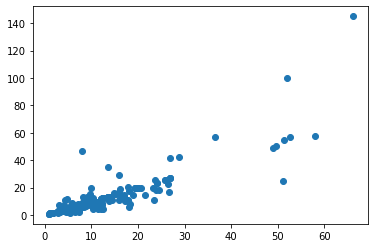

In [11]:
plt.scatter(y_pred_test/100000,y_test/100000)